# Classification : Logistic Regression with Regularization

이번 강의에서는 logistic regression 을 이용하여 분류 모델을 만드는 것을 응용하여, feature engineering과 overfitting 그리고 그 대처에 대해 공부한다.

먼저 본 강의에서 visualize를 위하여 아래의 라이브러리를 import 합니다.

In [1]:
import warnings
warnings.filterwarnings('ignore')     # 모든 경고 무시해줍니다... 

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

또한 오늘 강의 모델링을 위하여 아래의 라이브러리를 사용합니다.

In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
# 아래의 라이브러리는 나중에 설명하겠습니다. (오늘 강의에서 사용하지 않습니다)
#from sklearn.linear_model import LogisticRegressionCV
#from sklearn.model_selection import cross_val_score, StratifiedKFold
#from sklearn.model_selection import GridSearchCV    <- 나중에 사용합니다. 

마이크로칩 테스팅 하는 데이터를 사용합니다. 본 데이터를 간략히 설명하면, 마이크로칩을 생산하여 검수를 test 1과 test 2를 수행하여, 품질의 합격/불합격을 결정한 데이터를 갖고 있습니다. (물론 더 많은 검수 과정을 거치겠지요?)

언제나 그렇듯 데이터를 pandas를 이용하여 읽습니다. 

In [3]:
data = pd.read_csv('microchip_tests.txt',
                   header=None, names = ('test1','test2','released'))
data.head()

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


데이터의 sample size와 원래 갖고 있는 feature를 살펴봅니다.

In [4]:
data.shape

(118, 3)

raw data를 X feature matrix 와 y label vector로 다음과 같이 나눕니다.

In [5]:
X = data.iloc[:,:2].values
y = data.iloc[:,2].values
print(X);
print(Y);

[[ 0.051267   0.69956  ]
 [-0.092742   0.68494  ]
 [-0.21371    0.69225  ]
 [-0.375      0.50219  ]
 [-0.51325    0.46564  ]
 [-0.52477    0.2098   ]
 [-0.39804    0.034357 ]
 [-0.30588   -0.19225  ]
 [ 0.016705  -0.40424  ]
 [ 0.13191   -0.51389  ]
 [ 0.38537   -0.56506  ]
 [ 0.52938   -0.5212   ]
 [ 0.63882   -0.24342  ]
 [ 0.73675   -0.18494  ]
 [ 0.54666    0.48757  ]
 [ 0.322      0.5826   ]
 [ 0.16647    0.53874  ]
 [-0.046659   0.81652  ]
 [-0.17339    0.69956  ]
 [-0.47869    0.63377  ]
 [-0.60541    0.59722  ]
 [-0.62846    0.33406  ]
 [-0.59389    0.005117 ]
 [-0.42108   -0.27266  ]
 [-0.11578   -0.39693  ]
 [ 0.20104   -0.60161  ]
 [ 0.46601   -0.53582  ]
 [ 0.67339   -0.53582  ]
 [-0.13882    0.54605  ]
 [-0.29435    0.77997  ]
 [-0.26555    0.96272  ]
 [-0.16187    0.8019   ]
 [-0.17339    0.64839  ]
 [-0.28283    0.47295  ]
 [-0.36348    0.31213  ]
 [-0.30012    0.027047 ]
 [-0.23675   -0.21418  ]
 [-0.06394   -0.18494  ]
 [ 0.062788  -0.16301  ]
 [ 0.22984   -0.41155  ]


NameError: name 'Y' is not defined

데이터에 대한 이해도를 높이기 위하여, scatter plot을 이용하여 그려봅니다. 검수에 통과된 마이크로칩을 파란색, 불합격한 마이크로칩을 빨간색으로 아래 코드를 사용하여 그립니다. (scatter plot은 잘 사용하도록 합시다: 시각화는 데이터에 대한 이해도를 높입니다.) 

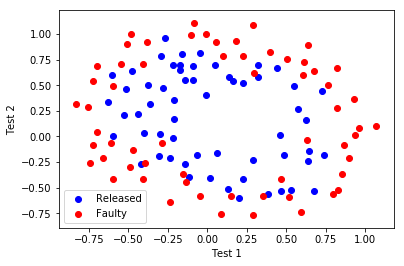

In [23]:
plt.scatter(X[y == 1, 0], X[y == 1, 1], c='blue', label='Released')
plt.scatter(X[y == 0, 0], X[y == 0, 1], c='red', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.legend();

아래의 plot_boundary 함수는 여러분이 직접 짜지 않아도 됩니다.( 나중에 boundary를 그리기 위하여 쓰는 함수입니다) 

In [24]:
def plot_boundary(clf, X, y, grid_step=.01, poly_featurizer=None):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))

    Z = clf.predict(poly_featurizer.transform(np.c_[xx.ravel(), yy.ravel()]))
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

이제 본격적으로, 지난 시간에 배운 logistic regression 을 사용하여 마이크로칩을 검수하는 알고리즘을 개발하여 봅시다.
과연 지난 시간에 배운 내용으로 될까요? 시각화를 했을 때 선으로 그어서 구분이 될 것 같았나요? 

확인해보도록 합시다.

먼저 traing 데이터와 test 데이터를 나누워 봅시다

In [25]:
from sklearn.model_selection  import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)


In [26]:
logit = LogisticRegression(C=10000.0)
logit.fit(X_train, y_train)

LogisticRegression(C=10000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

자 그렇다면, 우리가 구한 결과가 어떻게 나왔는지 decision boundary를 그려보도록 합시다.

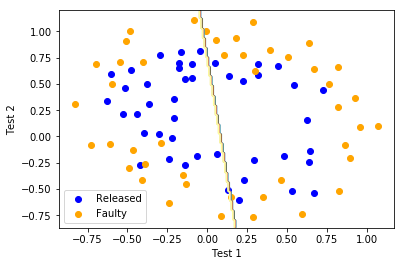

In [27]:
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='blue', label='Released')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.legend();

#######################decision boundary plot 하는 부분 #################
clf =logit
grid_step=.01
x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                     np.arange(y_min, y_max, grid_step))

Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)/*/
plt.contour(xx, yy, Z, cmap=plt.cm.Paired)


얼마나 잘 예측하였나요? 눈으로 봐도 결과가 안 좋은 것을 알 수 있습니다. 그렇다면 accuracy 를 구해봅시다. 

In [28]:
print("Accuracy on training set:", 
      round(logit.score(X_train, y_train), 3))


Accuracy on training set: 0.591


## Feature Engineering

자 우리가 갇고 있는 feature 는 2개 밖에 없었습니다. 그렇다면 logistic regression 으로 할 수 있는 것은 이게 최선이었습니다! 

Feature를 더 만들을 수는 없을까요? 

시각화 했을 때, decision boundary가 타원형이면 더 좋겠다는 생각은 안 했나요?

그렇다면 feature를 더 만드는 것은 어떨까요?    

x값을 제곱한 것을 만드는 것은 어떨까요? 

더 정확히   $x_1$, $x_2$ 가 있었을 때, $x_1$, $x_2$, $x_1^2$, $x_2^2$, $x_1 x_2$의 값을 더 만들어 보는 것은 어떨까요?

PolynomialFeatures 라는 함수가 대신 만들어 줍니다.

In [29]:
poly = PolynomialFeatures(degree=2)
X_poly_train = poly.fit_transform(X_train)
X_poly_train.shape

(88, 6)

이제 이 feature들을 이용하여 기존 모델을 개선해봅시다.

NameError: name 'X_poly' is not defined

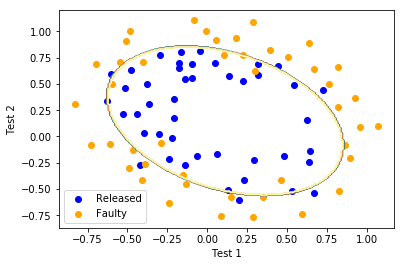

In [30]:
logit = LogisticRegression(C=10000.0)
logit.fit(X_poly_train, y_train)

plot_boundary(logit, X_train, y_train, grid_step=.01, poly_featurizer=poly)

plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='blue', label='Released')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_poly, y_train), 3))


훨씬 나은 결과 값을 볼 수 있습니다. accuracy 또한 향상되었습니다.

우리는 feature가 증가하면 증가할 수록 결과가 좋아지는 것을 확인하였습니다. 

앞에서 degree를 높여서 실험해보는 것은 어떨까요?

Accuracy on training set: 0.864


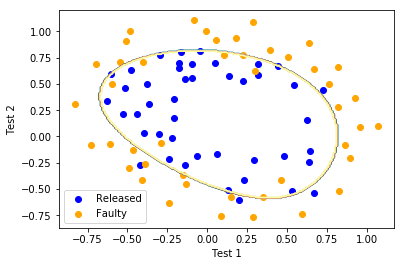

In [31]:
poly = PolynomialFeatures(degree=3)
X_poly = poly.fit_transform(X_train)

logit = LogisticRegression(C=10000.0)
logit.fit(X_poly, y_train)

plot_boundary(logit, X_train, y_train, grid_step=.01, poly_featurizer=poly)

plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='blue', label='Released')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_poly, y_train), 3))


더 개선되었습니다! 

## Overfitting

앞에서 feature 수를 늘이면 늘일 수록 잘 되는 것을 확인하였습니다. 

이제 polynomial feature를 degree 50으로 높여 해보도록 합시다.

Accuracy on training set: 0.898


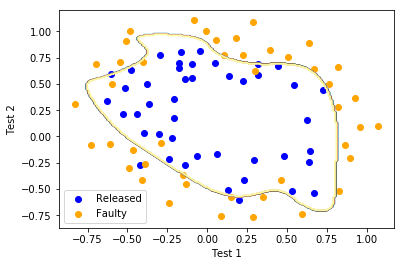

In [32]:
poly = PolynomialFeatures(degree=50)
X_poly = poly.fit_transform(X_train)

logit = LogisticRegression(C=10000.0)
logit.fit(X_poly, y_train)

plot_boundary(logit, X_train, y_train, grid_step=.01, poly_featurizer=poly)

plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='blue', label='Released')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_poly, y_train), 3))

실행시간도 오래걸렸지만, 상당히 만족스러운 결과가 나온 것을 확인할 수 있습니다. 시간을 투자하여 fitting한 보람이 있는 만큼... 

그러나 decision boundary가 상당히 어색하며, 억지로 끼워넣은 듯한 모습입니다. 

그렇다면, testing 데이터에 본 결과를 적용해보도록 합시다. 

In [33]:
X_poly_test = poly.fit_transform(X_test)
y_pred=logit.predict(X_poly_test)
print("Accuracy on testing set:", 
      round(logit.score(X_poly_test, y_test), 3))

Accuracy on testing set: 0.733


그 높던 accuracy 값이 0.733 으로 깎인 것을 확인할 수 있습니다! 

그렇다면, 직관적으로 그림을 봤을 때, 2차원에서 제일 잘 된 느낌을 받았는데, 그것을 적용해보는 것은 어떤가 확인해봅시다. (물론 training의 결과 값이 그리 만족 스럽지 않지만...)

Accuracy on training set: 0.841
Accuracy on testing set: 0.867


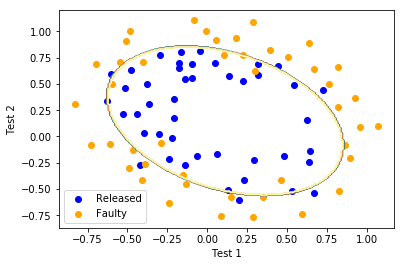

In [34]:
poly = PolynomialFeatures(degree=2)
X_poly = poly.fit_transform(X_train)

logit = LogisticRegression(C=10000.0)
logit.fit(X_poly, y_train)

plot_boundary(logit, X_train, y_train, grid_step=.01, poly_featurizer=poly)

plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='blue', label='Released')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_poly, y_train), 3))

X_poly_test = poly.fit_transform(X_test)
y_pred=logit.predict(X_poly_test)
print("Accuracy on testing set:", 
      round(logit.score(X_poly_test, y_test), 3))

만족스러운 testing 값이 나왔습니다. 

이것을 overfitting 이라고 합니다. training 할 때, 데이터에 너무 집중하여 최적하 한 것이 오히려 독이 되는 경우. 그렇다면, overfitting 을 방지하는 방법은 무엇이 있을까요?

## Logistic Regression Regularization

$J(w) = \left[\sum_i^n -y^{(i)}log(\phi(z^{(i)})-(1-y^{(i)})log(1-\phi(z^{(i)})) \right] + \frac {\lambda}{2} {\Vert w \Vert}^2$

regularization 은 모든 feature를 고려하되, 의미가 없는 feature의 weight가 0에 가깝게 penalty를 적용하는 수식입니다. 
위는 ridge regression이라고 합니다.

그렇다면, 아까 degree 50 으로 하였던 케이스에 ridge regression을 적용해봅시다.

Accuracy on training set: 0.864


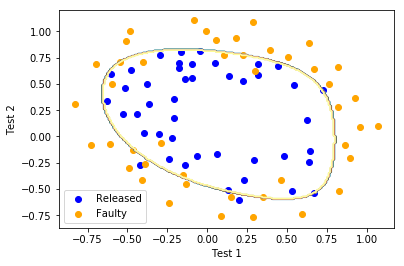

In [35]:
poly = PolynomialFeatures(degree=50)
X_poly = poly.fit_transform(X_train)

logit = LogisticRegression(penalty='l2', C=10)          ##  l2 가 ridge   (C는 ]lambda의 역수라고 생각하면 됨)
logit.fit(X_poly, y_train)

plot_boundary(logit, X_train, y_train, grid_step=.01, poly_featurizer=poly)

plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], c='blue', label='Released')
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], c='orange', label='Faulty')
plt.xlabel("Test 1")
plt.ylabel("Test 2")
plt.legend();

print("Accuracy on training set:", 
      round(logit.score(X_poly, y_train), 3))

In [36]:
X_poly

array([[ 1.00000000e+00,  1.37670000e-01,  5.75290000e-01, ...,
         5.65257356e-14,  2.36207528e-13,  9.87054761e-13],
       [ 1.00000000e+00,  5.92740000e-01, -7.40500000e-01, ...,
         1.91836609e-07, -2.39658213e-07,  2.99400929e-07],
       [ 1.00000000e+00, -2.07950000e-01,  1.73250000e-01, ...,
         1.23661220e-38, -1.03026239e-38,  8.58345558e-39],
       ...,
       [ 1.00000000e+00,  7.65550000e-01,  5.02190000e-01, ...,
         2.56811237e-15,  1.68464549e-15,  1.10510367e-15],
       [ 1.00000000e+00,  2.24080000e-01,  5.24120000e-01, ...,
         1.71191164e-15,  4.00413749e-15,  9.36562183e-15],
       [ 1.00000000e+00,  6.27300000e-01,  1.58630000e-01, ...,
         1.63473040e-39,  4.13386391e-40,  1.04536080e-40]])

50개의 feature 인데도, 아까와 다른 decision boundary인 것을 확인할 수 있습니다. (상당히 스무스 합니다)

In [37]:
X_poly_test = poly.fit_transform(X_test)
y_pred=logit.predict(X_poly_test)
print("Accuracy on testing set:", 
      round(logit.score(X_poly_test, y_test), 3))

Accuracy on testing set: 0.867


testing한 결과를 보면, 상당히 만족스러운 것을 확인할 수 있습니다! 